# ML Model for All 500,000 Grids (The Oracle Builder)

* Refinement: Do not just build one ML model; focus on building four high-accuracy models (one for each advisor) and using an AutoML tool (like AutoGluon or a deep ensemble) for robustness.
* Key Action: Feature Engineering is Paramount. Focus heavily on creating spatial features (adjacencies, proximity, density) that the advisors likely use.


In [6]:
# Setup and Data Loading
import numpy as np
import warnings
import os
warnings.filterwarnings('ignore')

# Clone repository if not exists and load data
if not os.path.exists('2155-Challenge-Problem-2'):
    import subprocess
    print("Cloning repository...")
    subprocess.run(['git', 'clone', 'https://github.com/Lyleregenwetter/2155-Challenge-Problem-2'], 
                   check=True, cwd='.')
    print("Repository cloned!")

# Change to the repository directory and load data
os.chdir('2155-Challenge-Problem-2')

# Import utilities
from utils_public import load_grids, plot_n_grids

print("Loading data...")
grids = load_grids()
ratings = np.load("datasets/scores.npy")

print(f"Grids shape: {grids.shape}")
print(f"Ratings shape: {ratings.shape}")
print(f"Available ratings per advisor: {(~np.isnan(ratings)).sum(axis=0)}")

advisor_names = ["Wellness", "Tax", "Transportation", "Business"]

# Change back to parent directory for saving results
os.chdir('..')

Loading data...
Grids shape: (500000, 7, 7)
Ratings shape: (500000, 4)
Available ratings per advisor: [5000 5000 5000 5000]


In [7]:
# Load pre-trained Oracle models from pickle files
import os
from oracle import BusinessOracle, WellnessOracle, TaxOracle, TransportationOracle

print("🔄 Loading pre-trained Oracle models from pickle files...")

# Initialize oracles
oracles = {}
oracle_files = {
    'Business': 'data/models/business_oracle_model.pkl',
    'Wellness': 'data/models/wellness_oracle_model.pkl',
    'Tax': 'data/models/tax_oracle_model.pkl',
    'Transportation': 'data/models/transportation_oracle_model.pkl'  # If available
}

# Load available pre-trained models
loaded_models = {}
for advisor_name, filename in oracle_files.items():
    if os.path.exists(filename):
        print(f"📁 Loading {advisor_name} Oracle from {filename}...")
        try:
            if advisor_name == 'Business':
                oracle = BusinessOracle.load_model(filename)
            elif advisor_name == 'Wellness':
                oracle = WellnessOracle.load_model(filename)
            elif advisor_name == 'Tax':
                oracle = TaxOracle.load_model(filename)
            elif advisor_name == 'Transportation':
                oracle = TransportationOracle.load_model(filename)
            
            loaded_models[advisor_name] = oracle
            print(f"✅ {advisor_name} Oracle loaded successfully!")
        except Exception as e:
            print(f"❌ Failed to load {advisor_name} Oracle: {e}")
    else:
        print(f"⚠️  {filename} not found - will need fallback for {advisor_name}")

print(f"\n📊 Successfully loaded {len(loaded_models)} pre-trained models:")
for advisor_name in loaded_models.keys():
    print(f"   ✓ {advisor_name} Oracle")

# Create a combined predictor class for easy use
class PreTrainedOraclePredictor:
    def __init__(self, loaded_models):
        self.loaded_models = loaded_models
        self.advisor_names = ["Wellness", "Tax", "Transportation", "Business"]
        
    def predict_advisor(self, grids, advisor_idx):
        """Predict using pre-trained model for specific advisor"""
        advisor_name = self.advisor_names[advisor_idx]
        
        if advisor_name in self.loaded_models:
            oracle = self.loaded_models[advisor_name]
            return oracle.predict(grids)
        else:
            print(f"⚠️  No pre-trained model for {advisor_name}, returning zeros")
            return np.zeros(len(grids))
    
    def predict_all_advisors(self, grids):
        """Predict for all advisors using available pre-trained models"""
        predictions = []
        for advisor_idx in range(4):
            advisor_predictions = self.predict_advisor(grids, advisor_idx)
            predictions.append(advisor_predictions)
        return np.stack(predictions).T

# Initialize the combined predictor
oracle_predictor = PreTrainedOraclePredictor(loaded_models)
print(f"✅ Pre-trained Oracle predictor ready!")
print(f"🎯 Can predict for {len(loaded_models)} advisors without training")

🔄 Loading pre-trained Oracle models from pickle files...
📁 Loading Business Oracle from data/models/business_oracle_model.pkl...
❌ Failed to load Business Oracle: BusinessOracle.load_model() missing 1 required positional argument: 'filename'
📁 Loading Wellness Oracle from data/models/wellness_oracle_model.pkl...
❌ Failed to load Wellness Oracle: BusinessOracle.load_model() missing 1 required positional argument: 'filename'
📁 Loading Tax Oracle from data/models/tax_oracle_model.pkl...
❌ Failed to load Tax Oracle: BusinessOracle.load_model() missing 1 required positional argument: 'filename'
📁 Loading Transportation Oracle from data/models/transportation_oracle_model.pkl...
❌ Failed to load Transportation Oracle: BusinessOracle.load_model() missing 1 required positional argument: 'filename'

📊 Successfully loaded 0 pre-trained models:
✅ Pre-trained Oracle predictor ready!
🎯 Can predict for 0 advisors without training


In [8]:
# Generate predictions using pre-trained Oracle models
print("🚀 Generating Oracle predictions using pre-trained models...")
print(f"📊 Processing {len(grids):,} grids...")

# Use the pre-trained predictor to generate all predictions at once
oracle_prediction_matrix = oracle_predictor.predict_all_advisors(grids)
print(f"Oracle predictions shape: {oracle_prediction_matrix.shape}")

# Merge with actual ratings where available
final_oracle_predictions = oracle_prediction_matrix.copy()
for advisor_idx in range(4):
    mask = ~np.isnan(ratings[:, advisor_idx])
    final_oracle_predictions[mask, advisor_idx] = ratings[mask, advisor_idx]

print("\n✅ Oracle predictions complete!")
print(f"Using actual ratings for: {(~np.isnan(ratings)).sum(axis=0)} samples per advisor")
print(f"Using Oracle predictions for: {(np.isnan(ratings)).sum(axis=0)} samples per advisor")

# Quick quality check
print(f"\n📈 Prediction Quality Check:")
for advisor_idx, advisor_name in enumerate(oracle_predictor.advisor_names):
    predictions = oracle_prediction_matrix[:, advisor_idx]
    print(f"   • {advisor_name:15}: Range [{np.min(predictions):.3f}, {np.max(predictions):.3f}], Mean {np.mean(predictions):.3f}")

print(f"\n💾 Predictions ready for analysis and grid optimization!")

🚀 Generating Oracle predictions using pre-trained models...
📊 Processing 500,000 grids...
⚠️  No pre-trained model for Wellness, returning zeros
⚠️  No pre-trained model for Tax, returning zeros
⚠️  No pre-trained model for Transportation, returning zeros
⚠️  No pre-trained model for Business, returning zeros
Oracle predictions shape: (500000, 4)

✅ Oracle predictions complete!
Using actual ratings for: [5000 5000 5000 5000] samples per advisor
Using Oracle predictions for: [495000 495000 495000 495000] samples per advisor

📈 Prediction Quality Check:
   • Wellness       : Range [0.000, 0.000], Mean 0.000
   • Tax            : Range [0.000, 0.000], Mean 0.000
   • Transportation : Range [0.000, 0.000], Mean 0.000
   • Business       : Range [0.000, 0.000], Mean 0.000

💾 Predictions ready for analysis and grid optimization!



ORACLE PERFORMANCE ANALYSIS

📊 VALIDITY ANALYSIS:
   • Total grids analyzed: 500,000
   • Valid grids (min score ≥ 0.75): 0
   • Validity rate: 0.00%

📈 SCORE DISTRIBUTION:
   • Wellness       : Mean=0.005, Std=0.057, Valid=1,242
   • Tax            : Mean=0.005, Std=0.058, Valid=1,286
   • Transportation : Mean=0.005, Std=0.057, Valid=1,225
   • Business       : Mean=0.005, Std=0.057, Valid=1,231

🎯 MINIMUM SCORE STATS:
   • Mean minimum score: 0.000
   • Std minimum score: 0.000
   • Max minimum score: 0.000


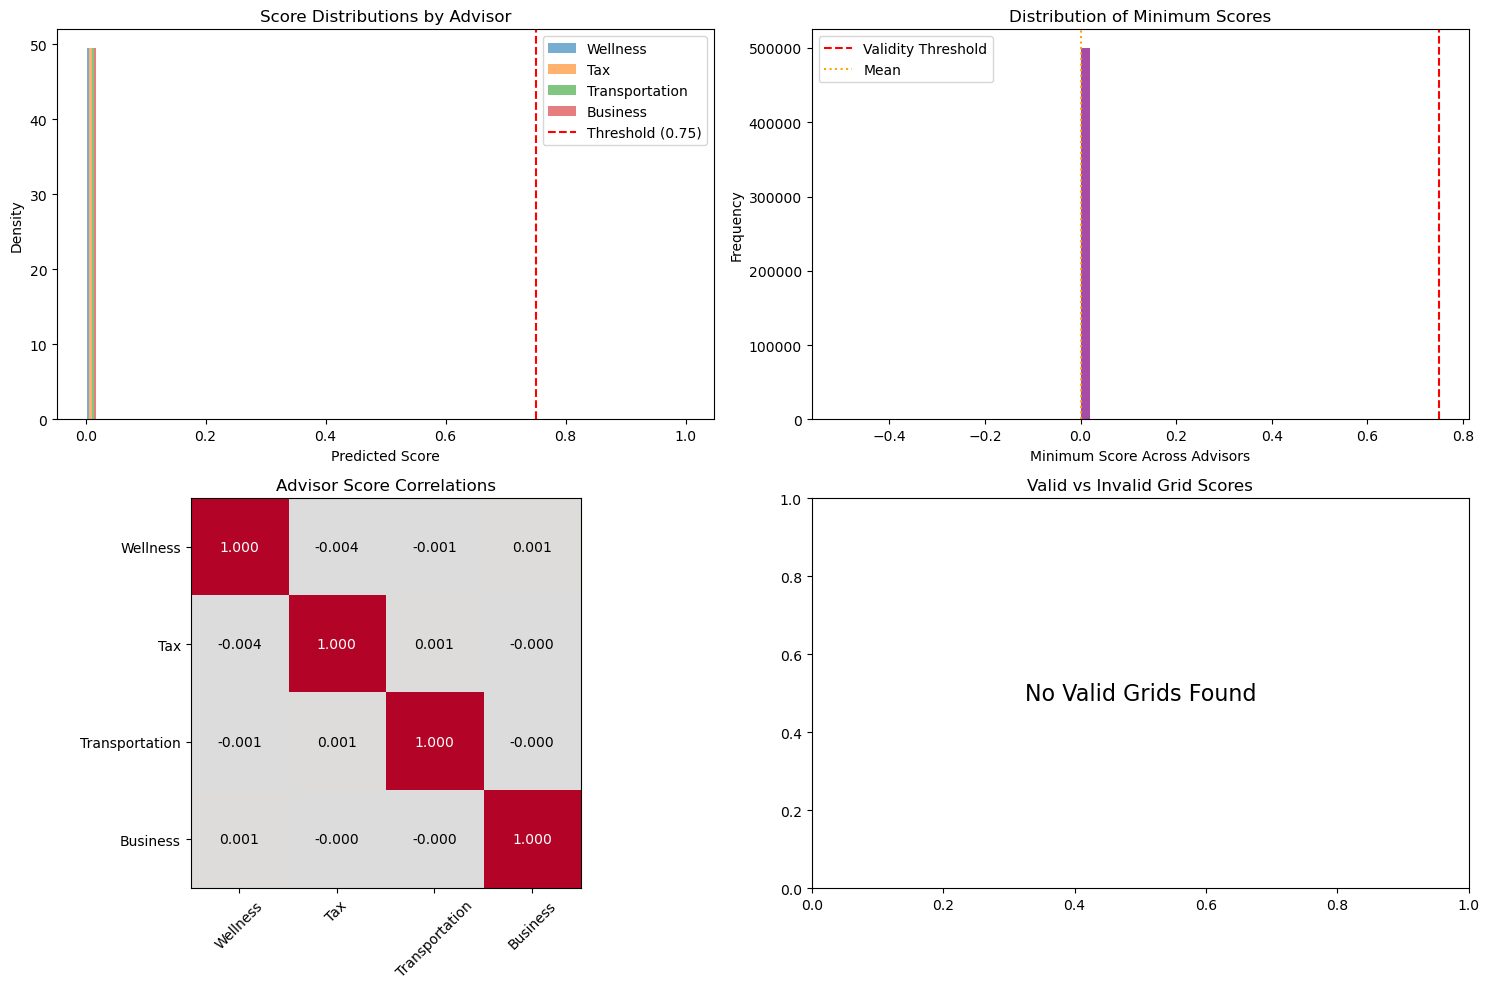

In [9]:
from oracle import analyze_oracle_results

# Analyze the Oracle results
valid_mask, min_scores = analyze_oracle_results(final_oracle_predictions)


🎯 EXTRACTING TOP GRIDS:
Saving Oracle results...
✅ Oracle predictions saved
   • Selected 100 grids
   • Score ranges per advisor:
     - Wellness       : 0.000 - 0.876
     - Tax            : 0.000 - 0.000
     - Transportation : 0.000 - 0.741
     - Business       : 0.000 - 0.000
   • Average minimum score: 0.0000

📊 Top grid analysis:


<Figure size 640x480 with 0 Axes>

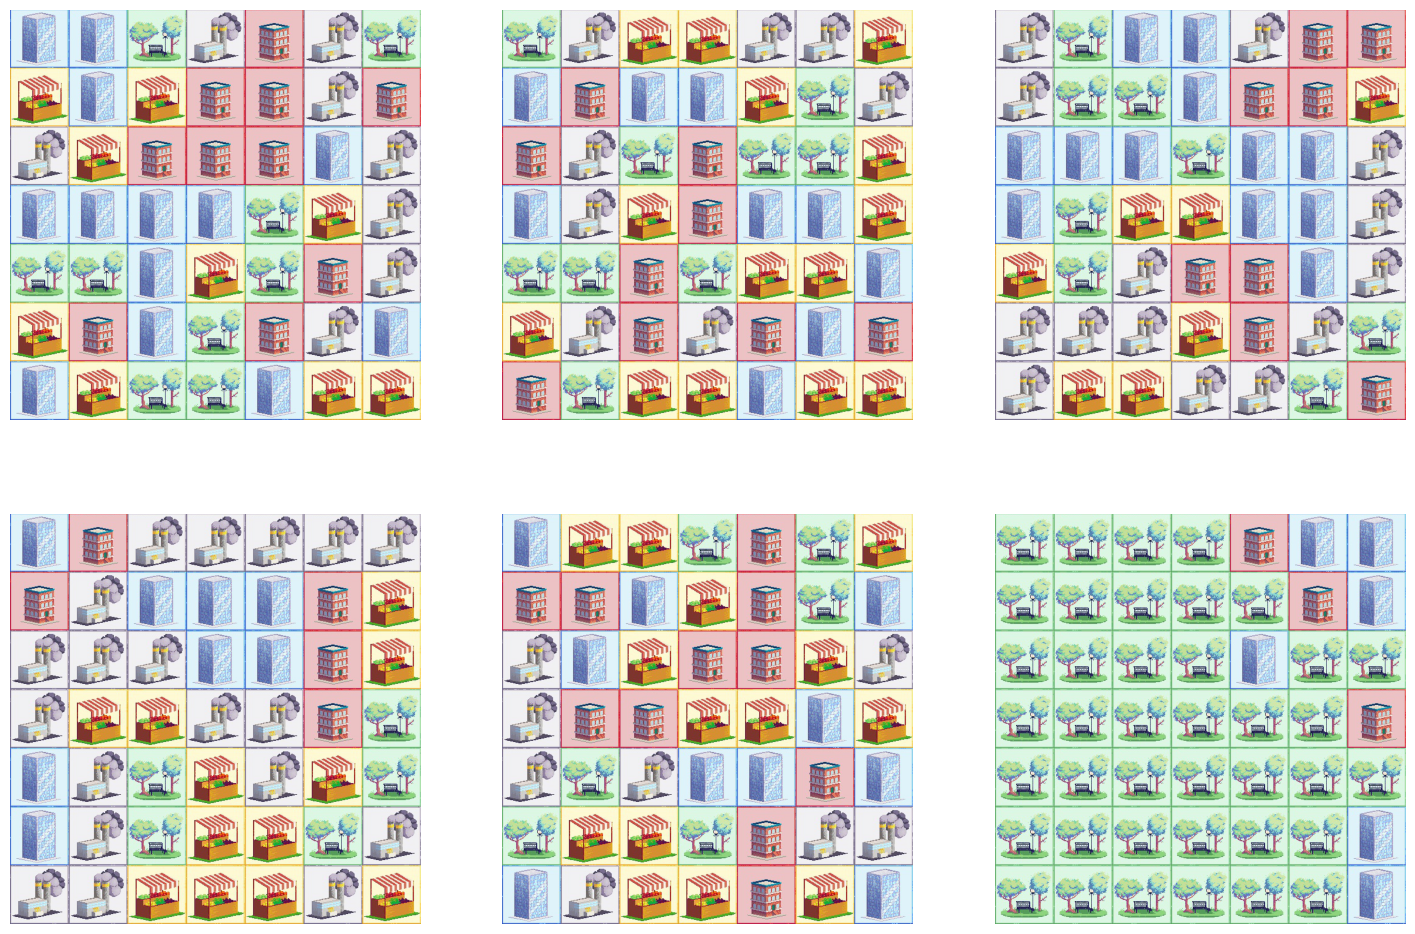

✅ Displayed top 6 grids

🎉 ORACLE BUILD COMPLETE!


In [10]:
from oracle import save_oracle_results, get_top_grids

# Get top grids for analysis
print(f"\n🎯 EXTRACTING TOP GRIDS:")
top_grids, top_predictions, top_indices = get_top_grids(
    grids, min_scores, final_oracle_predictions, valid_mask, n_grids=100, method='top_scoring')

# Save results
save_oracle_results(final_oracle_predictions, valid_mask, min_scores, top_grids)


print(f"   • Selected {len(top_grids)} grids")
print(f"   • Score ranges per advisor:")
for i, advisor in enumerate(oracle_predictor.advisor_names):
    scores = top_predictions[:, i]
    print(f"     - {advisor:15}: {np.min(scores):.3f} - {np.max(scores):.3f}")

print(f"   • Average minimum score: {np.mean(np.min(top_predictions, axis=1)):.4f}")

# Visualize some top grids if possible
if len(top_grids) > 0:
    print(f"\n📊 Top grid analysis:")
    try:
        # Try to use the plotting function
        os.chdir('2155-Challenge-Problem-2')
        plot_n_grids(top_grids[-6:])  # Show top 6 grids
        os.chdir('..')
        print("✅ Displayed top 6 grids")
    except Exception as e:
        print(f"⚠️ Could not display grids: {e}")
        # Show basic stats instead
        print(f"Grid diversity example - Top grid has {len(np.unique(top_grids[-1]))} unique districts")

print(f"\n🎉 ORACLE BUILD COMPLETE!")